## Exercise 1: Viola & Jones Face Detection (5 Points)

Implement the Viola & Jones face detection algorithm (without cascading features) as described in the lecture. Use the provided code skeleton and complete the missing parts. Test your implementation on the provided dataset and report the detection accuracy.

## Tasks:
1. Implement the `integral_image` function to compute the integral image. (0.5 Points)
1. Implement the `rect_sum` function to compute the sum of pixel values in a rectangular region using the integral image. (0.5 Points)
1. Implement the `HaarFeature` class to represent Haar-like features and compute their values. (1 Point)
1. Implement the `generate_haar_features` function to generate a set of Haar features for given image dimensions. (0.5 Points)
1. Implement the `WeakClassifier` class to represent a weak classifier based on a Haar feature. (0.5 Points)
1. Implement the `train_adaboost` function to train the AdaBoost classifier using Haar features. (1 Point)
1. Implement the `strong_classifier_predict` function to make predictions using the classifiers and alphas. (0.5 Points)
1. Evaluate your implementation on the provided dataset and report the detection accuracy. (0.5 Points)

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

### Data loading

Number of face images: 500
Number of non-face images: 500


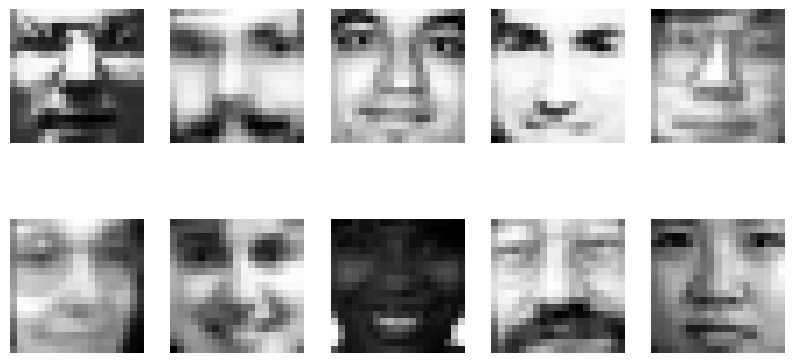

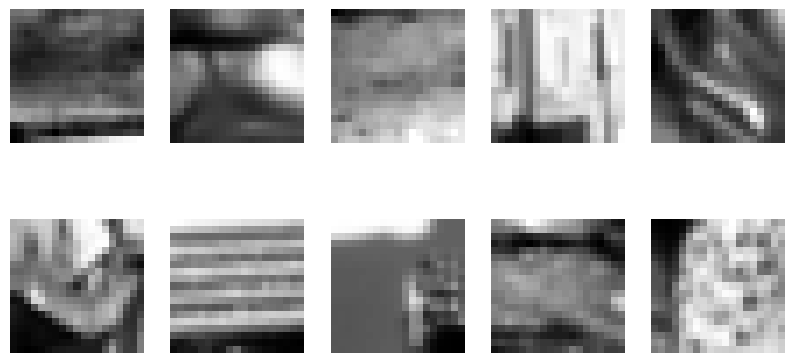

In [3]:
face_images = np.load('face_datanpy.sec')
non_face_images = np.load('non_face_datanpy.sec')

num_face = face_images.shape[0]
num_non_face = non_face_images.shape[0]

print(f'Number of face images: {num_face}')
print(f'Number of non-face images: {num_non_face}')

# visualize some face images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(face_images[i], cmap='gray')
    ax.axis('off')
plt.show()

# visualize some non-face images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(non_face_images[i], cmap='gray')
    ax.axis('off')
plt.show()

In [4]:
X = np.concatenate([face_images, non_face_images])
y = np.concatenate([
    np.ones(num_face),
    -np.ones(num_non_face)
])


In [5]:
# split into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1000, 19, 19) (1000,)
(800, 19, 19) (200, 19, 19) (800,) (200,)


Text(0.5, 1.0, 'Integral Image')

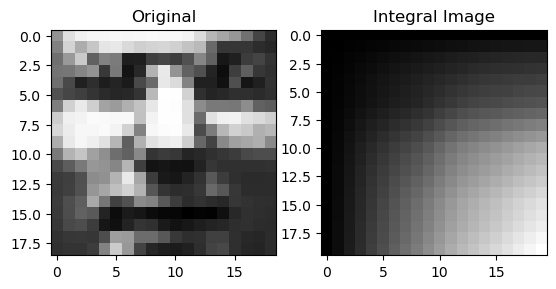

In [6]:
def integral_image(img: np.ndarray) -> np.ndarray:
    """
    Compute the integral image with a top/left zero border.
    If img has shape (H, W), returns an array of shape (H+1, W+1).
    """
    img = img.astype(np.float64, copy=False)
    c = img.cumsum(axis=0).cumsum(axis=1)
    H, W = img.shape
    ii = np.zeros((H + 1, W + 1), dtype=np.float64)
    ii[1:, 1:] = c
    return ii
    
img = X[0]
ii = integral_image(img)

plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(ii, cmap="gray")
plt.title("Integral Image")

In [8]:
def rect_sum(ii: np.ndarray, x: int, y: int, w: int, h: int) -> float:
    """
    Sum of pixels in rectangle using integral image.
    Rectangle top-left = (x, y), size = (w, h)
    Works with padded integral image (H+1, W+1).
    """
    x1, y1 = x, y
    x2, y2 = x + w, y + h
    return float(ii[y2, x2] - ii[y1, x2] - ii[y2, x1] + ii[y1, x1])

In [11]:
class HaarFeature:
    def __init__(self, feature_type: str, position: Tuple[int, int], size: Tuple[int, int]):
        self.feature_type = feature_type
        self.position = position  # (x, y)
        self.size = size          # (w, h)

    def compute(self, ii: np.ndarray) -> float:
        x, y = self.position
        w, h = self.size

        if self.feature_type == 'two-rectangle-horizontal':
            # two vertical bars: left - right
            w2 = w // 2
            left = rect_sum(ii, x, y, w2, h)
            right = rect_sum(ii, x + w2, y, w2, h)
            return left - right

        elif self.feature_type == 'two-rectangle-vertical':
            # two horizontal bars: top - bottom
            h2 = h // 2
            top = rect_sum(ii, x, y, w, h2)
            bottom = rect_sum(ii, x, y + h2, w, h2)
            return top - bottom

        else:
            raise ValueError(f"Unknown feature type: {self.feature_type}")

In [12]:
# Nothing to change here
def visualize_feature(img, feature: HaarFeature):
    vis = img.copy()
    x, y = feature.position
    w, h = feature.size
    rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none')
    plt.imshow(vis, cmap="gray")
    plt.gca().add_patch(rect)
    plt.title(feature.feature_type)
    plt.show()

In [15]:
def generate_haar_features(img_size: Tuple[int, int] = (19, 19)) -> List[HaarFeature]:
    """
    Generate all valid 2-rectangle Haar features for a given image size (W, H).
    """
    W, H = img_size
    features: List[HaarFeature] = []

    # Strides to control feature count/speed
    pos_step = 1
    size_step = 1

    # two-rectangle-horizontal: width divisible by 2
    for h in range(1, H + 1, size_step):
        for w in range(2, W + 1, 2 * size_step):
            for y in range(0, H - h + 1, pos_step):
                for x in range(0, W - w + 1, pos_step):
                    features.append(HaarFeature('two-rectangle-horizontal', (x, y), (w, h)))

    # two-rectangle-vertical: height divisible by 2
    for h in range(2, H + 1, 2 * size_step):
        for w in range(1, W + 1, size_step):
            for y in range(0, H - h + 1, pos_step):
                for x in range(0, W - w + 1, pos_step):
                    features.append(HaarFeature('two-rectangle-vertical', (x, y), (w, h)))

    return features


In [16]:
class WeakClassifier:
    def __init__(self, feature: HaarFeature, threshold: float, polarity: int):
        """
        polarity ∈ {+1, -1}
        """
        self.feature = feature
        self.threshold = threshold
        self.polarity = polarity

    def predict(self, ii: np.ndarray) -> int:
        value = self.feature.compute(ii)
        # +1 if polarity * value < polarity * threshold, else -1
        return 1 if (self.polarity * value) < (self.polarity * self.threshold) else -1


In [19]:
def _best_threshold_and_polarity(feature_values: np.ndarray, labels: np.ndarray, weights: np.ndarray):
    """
    For a single feature across all samples, find threshold and polarity
    minimizing weighted classification error.
    """
    order = np.argsort(feature_values)
    f = feature_values[order]
    y = labels[order]
    w = weights[order]

    w_pos = w * (y == 1)
    w_neg = w * (y == -1)

    cum_pos = np.cumsum(w_pos)
    cum_neg = np.cumsum(w_neg)
    total_pos = cum_pos[-1] if cum_pos.size else 0.0
    total_neg = cum_neg[-1] if cum_neg.size else 0.0

    # Polarity +1: predict +1 if f < theta
    err_plus = cum_neg + (total_pos - cum_pos)
    # Polarity -1: predict +1 if f > theta
    err_minus = (total_neg - cum_neg) + cum_pos

    k_plus = int(np.argmin(err_plus))
    k_minus = int(np.argmin(err_minus))
    e_plus = float(err_plus[k_plus])
    e_minus = float(err_minus[k_minus])

    if e_plus <= e_minus:
        best_err = e_plus
        best_polarity = +1
        k = k_plus
    else:
        best_err = e_minus
        best_polarity = -1
        k = k_minus

    # Threshold between f[k] and f[k+1]; handle edge case
    if k < len(f) - 1:
        theta = 0.5 * (f[k] + f[k + 1])
    else:
        eps = 1e-9
        theta = f[k] + eps if best_polarity == +1 else f[k] - eps

    return best_err, theta, best_polarity


def train_adaboost(features, integral_images, labels, T=10):
    """
    Train an AdaBoost classifier from Haar-feature weak classifiers.
    """
    n = len(labels)
    weights = np.ones(n, dtype=np.float64) / n

    classifiers = []
    alphas = []

    # Precompute feature responses for speed: F[feat_idx, sample_idx]
    F = np.zeros((len(features), n), dtype=np.float64)
    for j, feat in enumerate(features):
        for i in range(n):
            F[j, i] = feat.compute(integral_images[i])

    for t in range(T):
        # Normalize weights
        weights = weights / max(weights.sum(), 1e-12)

        best_err = np.inf
        best_idx = None
        best_theta = None
        best_pol = None

        # Pick best weak learner this round
        for j in range(len(features)):
            err, theta, pol = _best_threshold_and_polarity(F[j, :], labels, weights)
            if err < best_err:
                best_err = err
                best_idx = j
                best_theta = theta
                best_pol = pol

        # Alpha (stability via clamping)
        eps = 1e-12
        e = np.clip(best_err, eps, 1 - eps)
        alpha = 0.5 * np.log((1 - e) / e)

        # Store classifier
        clf = WeakClassifier(features[best_idx], best_theta, best_pol)
        classifiers.append(clf)
        alphas.append(alpha)

        # Update weights: w_i <- w_i * exp(-alpha * y_i * h_i)
        fvals = F[best_idx, :]
        preds = np.where(best_pol * (fvals - best_theta) < 0, 1, -1)
        weights *= np.exp(-alpha * labels * preds)

        # Optional logging:
        # print(f"[{t+1}/{T}] err={best_err:.4f} alpha={alpha:.4f} pol={best_pol} theta={best_theta:.3f}")

    return classifiers, alphas


In [20]:
def strong_classifier_predict(ii, classifiers, alphas):
    """
    Make prediction using the strong classifier: sign(sum_t alpha_t * h_t(x))
    """
    score = 0.0
    for clf, a in zip(classifiers, alphas):
        score += a * clf.predict(ii)
    return 1 if score >= 0 else -1


Generated features: 34,200
Train accuracy: 1.0000
Test  accuracy: 0.9700
Feature 1: type=two-rectangle-vertical, pos=(1, 3), size=(17, 6), alpha=1.065


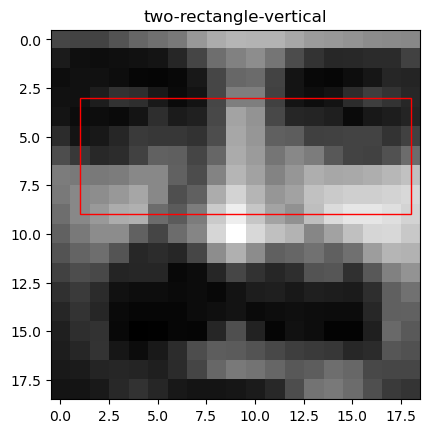

Feature 2: type=two-rectangle-horizontal, pos=(8, 4), size=(2, 9), alpha=0.786


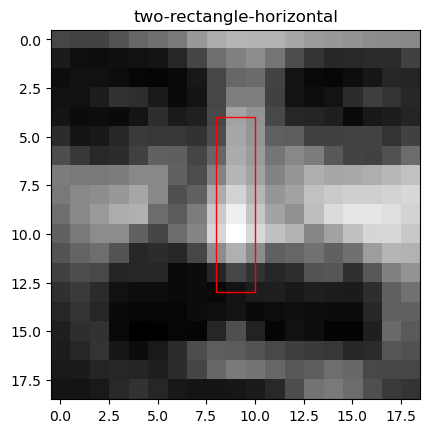

Feature 3: type=two-rectangle-horizontal, pos=(9, 3), size=(2, 9), alpha=0.709


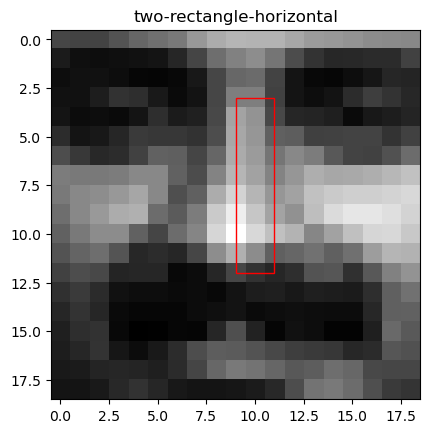

Feature 4: type=two-rectangle-vertical, pos=(6, 0), size=(7, 18), alpha=0.695


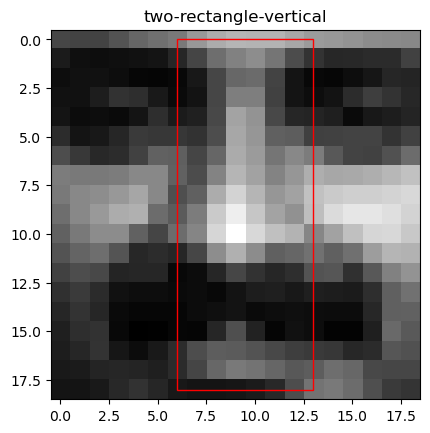

Feature 5: type=two-rectangle-horizontal, pos=(13, 18), size=(6, 1), alpha=0.637


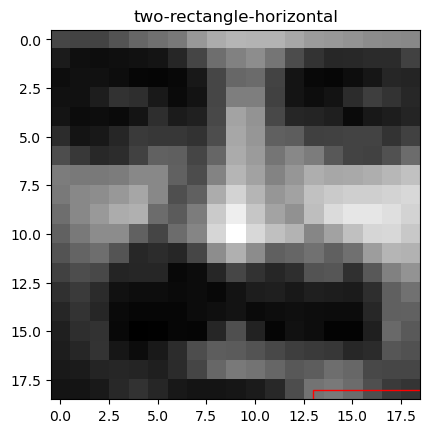

In [21]:
# Preparing integral images
ii_train = [integral_image(im) for im in X_train]
ii_test  = [integral_image(im) for im in X_test]

# Generating Haar features (assuming window equals image size)
H, W = X_train.shape[1], X_train.shape[2]
features = generate_haar_features(img_size=(W, H))
print(f"Generated features: {len(features):,}")

# Training AdaBoost (increase T for higher accuracy; watching training time)
T = 20
classifiers, alphas = train_adaboost(features, ii_train, y_train, T=T)

# Predict
y_pred_train = np.array([strong_classifier_predict(ii, classifiers, alphas) for ii in ii_train])
y_pred_test  = np.array([strong_classifier_predict(ii, classifiers, alphas) for ii in ii_test])

# Accuracy
acc_train = (y_pred_train == y_train).mean()
acc_test  = (y_pred_test  == y_test ).mean()
print(f"Train accuracy: {acc_train:.4f}")
print(f"Test  accuracy: {acc_test:.4f}")

# Visualizing a few selected features on a positive sample
pos_idx = np.where(y_train == 1)[0][0]
for i in range(min(5, len(classifiers))):
    f = classifiers[i].feature
    print(f"Feature {i+1}: type={f.feature_type}, pos={f.position}, size={f.size}, alpha={alphas[i]:.3f}")
    visualize_feature(X_train[pos_idx], f)
